In [794]:
import math
import numpy
from matplotlib import pyplot

# BEM method

In [795]:
#Q = 2000/3    #strength of the source-sheet,stb/d
h=25.26        #thickness of local gridblock,ft
phi=0.2        #porosity 
kx=200         #pemerability in x direction,md
ky=200         #pemerability in y direction,md
kr=kx/ky       #pemerability ratio
miu=1          #viscosity,cp

Nw=1           #Number of well
Qwell_1=2000   #Flow rate of well 1
Boundary_V=-400 #boundary velocity ft/day

## Boundary Discretization
we will create a discretization of the body geometry into panels (line segments in 2D). A panel's attributes are: its starting point, end point and mid-point, its length and its orientation. See the following figure for the nomenclature used in the code and equations below.
<img src="./resources/PanelLocal.png" width="300">
<center>Figure 1. Nomenclature of the boundary element in the local coordinates</center>
### Create panel and well class

In [796]:
class Panel:
    """Contains information related to a panel."""
    def __init__(self, xa, ya, xb, yb):
        """Creates a panel.
        
        Arguments
        ---------
        xa, ya -- Cartesian coordinates of the first end-point.
        xb, yb -- Cartesian coordinates of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        
        # orientation of the panel (angle between x-axis and panel)
        self.sinalpha=(yb-ya)/self.length
        self.cosalpha=(xb-xa)/self.length
        
        self.Q = 0.                                # source strength
        self.U = 0.                                # velocity component
        self.V = 0.                                # velocity component
        self.P = 0.                                # pressure coefficient

class Well:
    """Contains information related to a panel."""
    def __init__(self, xw, yw,rw,Q):
        """Creates a panel.
        
        Arguments
        ---------
        xw, yw -- Cartesian coordinates of well source.
        Q      -- Flow rate of well source.
        rw     -- radius of well source.
        """
        self.xw, self.yw = xw, yw
        
        self.Q = Q                               # source strength
        self.rw = rw                                # velocity component
     

We create a node distribution on the boundary that is refined near the corner with cosspace function

In [797]:
def cosspace(st,ed,N):
    N=N+1
    AngleInc=numpy.pi/(N-1)
    CurAngle = AngleInc
    space=numpy.linspace(0,1,N)
    space[0]=st
    for i in range(N-1):
        space[i+1] = 0.5*numpy.abs(ed-st)*(1 - math.cos(CurAngle));
        CurAngle += AngleInc
    if ed<st:
        space[0]=ed
        space=space[::-1]
    return space

### Discretize boundary element along the boundary 
Here we implement BEM in a squre grid

In [798]:
N=80     #Number of boundary element
Nbd=20   #Number of boundary element in each boundary
Dx=1.    #Grid block length in X direction
Dy=1.    #Gird block lenght in Y direction

#Create the array
x_ends = numpy.linspace(0, Dx, N)    # computes a 1D-array for x
y_ends = numpy.linspace(0, Dy, N)    # computes a 1D-array for y
interval=cosspace(0,Dx,Nbd)
rinterval=cosspace(Dx,0,Nbd)
#interval=numpy.linspace(0,1,Nbd+1)
#rinterval=numpy.linspace(1,0,Nbd+1)

#Define the rectangle boundary


for i in range(Nbd):
    x_ends[i]=0
    y_ends[i]=interval[i]

for i in range(Nbd):
    x_ends[i+Nbd]=interval[i]
    y_ends[i+Nbd]=Dy
    
for i in range(Nbd):
    x_ends[i+Nbd*2]=Dx
    y_ends[i+Nbd*2]=rinterval[i]
    
for i in range(Nbd):
    x_ends[i+Nbd*3]=rinterval[i]
    y_ends[i+Nbd*3]=0
    
x_ends,y_ends=numpy.append(x_ends, x_ends[0]), numpy.append(y_ends, y_ends[0])

#Define the panel
panels = numpy.empty(N, dtype=object)
for i in range(N):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    
#Define the well
wells = numpy.empty(Nw, dtype=object)

wells[0]=Well(Dx/2,Dy/2,0.025,Qwell_1)

In [799]:
#for i in range(N):
 #   print("Panel Coordinate (%s,%s) sina,cosa (%s,%s) " % (panels[i].xc,panels[i].yc,panels[i].sinalpha,panels[i].cosalpha))
#print("Well Location (%s,%s) radius: %s Flow rate:%s  " % (wells[0].xw,wells[0].yw,wells[0].rw,wells[0].Q))

### Plot boundary elements and wells

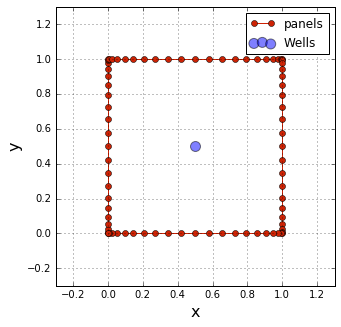

In [800]:
#Plot the panel
%matplotlib inline

val_x, val_y = 0.3, 0.3
x_min, x_max = min(panel.xa for panel in panels), max(panel.xa for panel in panels)
y_min, y_max = min(panel.ya for panel in panels), max(panel.ya for panel in panels)
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)

size = 5
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)

pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa), 
         numpy.append([panel.ya for panel in panels], panels[0].ya), 
         linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305');
pyplot.scatter(wells[0].xw,wells[0].yw,s=100,alpha=0.5)

pyplot.legend(['panels', 'Wells'], 
           loc=1, prop={'size':12})

## Boundary element implementation
<img src="./resources/BEMscheme2.png" width="400">
<center>Figure 2. Representation of a local gridblock with boundary elements</center>



Generally, the influence of all the j panels on the i BE node can be expressed as follows:

\begin{matrix}
{{c}_{ij}}{{p}_{i}}+{{p}_{i}}\int_{{{s}_{j}}}{{{H}_{ij}}d{{s}_{j}}}=({{v}_{i}}\cdot \mathbf{n})\int_{{{s}_{j}}}{{{G}_{ij}}}d{{s}_{j}}
\end{matrix}
Where,

${{c}_{ij}}$  is the free term, cased by source position.


<center>${{c}_{ij}}=\left\{ \begin{matrix}
   \begin{matrix}
   1 & \text{source j on the internal domain}  \\
\end{matrix}  \\
   \begin{matrix}
   0.5 & \text{source j on the boundary}  \\
\end{matrix}  \\
   \begin{matrix}
   0 & \text{source j on the external domain}  \\
\end{matrix}  \\
\end{matrix} \right.$</center>

$\int_{{{s}_{j}}}{{{H}_{ij}}d{{s}_{j}}\text{ }}$ is the integrated effect of the boundary element source i on the resulting normal flux at BE node j. 

$\int_{{{s}_{j}}}{{{G}_{ij}}}d{{s}_{j}}$ is the is the integrated effect of the boundary element source i on the resulting pressure at BE node j

### Line segment source solution for pressure and velocity (Derived recently)

The integrated effect can be formulated using line segment source solution, which givs:

\begin{equation}
\int_{{{s}_{j}}}{{{G}_{ij}}}d{{s}_{j}}=B{{Q}_{w}}=P({{{x}'}_{i}},{{{y}'}_{i}})=-\frac{70.60\mu }{h\sqrt{{{k}_{x}}{{k}_{y}}}}\int_{t=0}^{t={{l}_{j}}}{\ln \left\{ {{({x}'-t\cos {{\alpha }_{j}})}^{2}}+\frac{{{k}_{x}}}{{{k}_{y}}}{{({y}'-t\sin {{\alpha }_{j}})}^{2}} \right\}dt}\cdot {{Q}_{w}}
\end{equation}

\begin{equation}
\int_{{{s}_{j}}}{{{H}_{ij}}d{{s}_{j}}\text{ }}={{v}_{i}}(s)\cdot {{\mathbf{n}}_{i}}=-{{u}_{i}}\sin {{\alpha }_{i}}+{{v}_{i}}\cos {{\alpha }_{i}}
\end{equation}

Where,

\begin{equation}
u\left( {{{{x}'}}_{i}},{{{{y}'}}_{i}} \right)={{A}_{u}}{{Q}_{j}}=\frac{0.8936}{h\phi }\sqrt{\frac{{{k}_{x}}}{{{k}_{y}}}}\int_{t=0}^{t={{l}_{j}}}{\frac{{{{{x}'}}_{i}}-t\cos {{\alpha }_{j}}}{{{\left( {{{{x}'}}_{i}}-t\cos {{\alpha }_{j}} \right)}^{2}}+\frac{{{k}_{x}}}{{{k}_{y}}}{{({{{{y}'}}_{i}}-t\sin {{\alpha }_{j}})}^{2}}}dt}\cdot {{Q}_{j}}
\end{equation}

\begin{equation}
v\left( {{{{x}'}}_{i}},{{{{y}'}}_{i}} \right)={{A}_{v}}{{Q}_{j}}=\frac{0.8936}{h\phi }\sqrt{\frac{{{k}_{x}}}{{{k}_{y}}}}\int_{t=0}^{t={{l}_{j}}}{\frac{{{{{y}'}}_{i}}-t\sin {{\alpha }_{j}}}{{{\left( {{{{x}'}}_{i}}-t\cos {{\alpha }_{j}} \right)}^{2}}+\frac{{{k}_{x}}}{{{k}_{y}}}{{({{{{y}'}}_{i}}-t\sin {{\alpha }_{j}})}^{2}}}dt}\cdot {{Q}_{j}}
\end{equation}



## Line segment source Integration function (Bij and Aij)

In [801]:
#Panel infuence factor Bij
def InflueceP(x, y, panel):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the point.
    panel -- panel which contribution is evaluated.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
#Transfer global coordinate point(x,y) to local coordinate
    x=x-panel.xa
    y=y-panel.ya
    L1=panel.length
    
#Calculate the pressure and velocity influence factor
    a=panel.cosalpha**2+kr*panel.sinalpha**2
    b=x*panel.cosalpha+kr*panel.sinalpha*y
    c=y*panel.cosalpha-x*panel.sinalpha
    dp=70.6*miu/h/math.sqrt(kx*ky)
    Cp = dp/a*(
                             (
                              b*math.log(x**2-2*b*L1+a*L1**2+kr*y**2)
                             -L1*a*math.log((x-L1*panel.cosalpha)**2+kr*(y-L1*panel.sinalpha)**2)
                             +2*math.sqrt(kr)*c*math.atan((b-a*L1)/math.sqrt(kr)/c)
                             )
                             -
                             (
                               b*math.log(x**2+kr*y**2)
                               +2*math.sqrt(kr)*c*math.atan((b)/math.sqrt(kr)/c)
                             )         
                )
    #debug
    #print("a: %s b:%s c:%s  " % (a,b,c))
    #angle=math.atan((b-a*L1)/math.sqrt(kr)/c)*180/numpy.pi
    #print("Magic angle:%s"% angle)
    return Cp

def InflueceU(x, y, panel):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the point.
    panel -- panel which contribution is evaluated.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
#Transfer global coordinate point(x,y) to local coordinate
    x=x-panel.xa
    y=y-panel.ya
    L1=panel.length

#Calculate the pressure and velocity influence factor
    a=panel.cosalpha**2+kr*panel.sinalpha**2
    b=x*panel.cosalpha+kr*panel.sinalpha*y
    c=y*panel.cosalpha-x*panel.sinalpha
    dv=-0.4468/h/phi*math.sqrt(kx/ky)
    Cu = dv/a*(
                             ( 
                            panel.cosalpha*math.log(x**2-2*b*L1+a*L1**2+kr*y**2)+ 2*math.sqrt(kr)*panel.sinalpha*math.atan((a*L1-b)/math.sqrt(kr)/c) 
                             )
                            -
                             (
                            panel.cosalpha*math.log(x**2+kr*y**2)+2*math.sqrt(kr)*panel.sinalpha*math.atan((-b)/math.sqrt(kr)/c)
                             )    
                     )  
    #print("a: %s b:%s c:%s  " % (a,b,c))
    #angle=math.atan((b-a*L1)/math.sqrt(kr)/c)*180/numpy.pi
    #print("Magic angle:%s"% angle)
    return Cu

def InflueceV(x, y, panel):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the point.
    panel -- panel which contribution is evaluated.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
#Transfer global coordinate point(x,y) to local coordinate
    x=x-panel.xa
    y=y-panel.ya
    L1=panel.length

#Calculate the pressure and velocity influence factor
    a=panel.cosalpha**2+kr*panel.sinalpha**2
    b=x*panel.cosalpha+kr*panel.sinalpha*y
    c=y*panel.cosalpha-x*panel.sinalpha
    dv=-0.4468/h/phi*math.sqrt(kx/ky)
    Cv = dv/a*(
                             ( 
                            panel.sinalpha*math.log(x**2-2*b*L1+a*L1**2+kr*y**2)+ 2*math.sqrt(1/kr)*panel.cosalpha*math.atan((b-a*L1)/math.sqrt(kr)/c) 
                             )
                            -
                             (
                            panel.sinalpha*math.log(x**2+kr*y**2)+2*math.sqrt(1/kr)*panel.cosalpha*math.atan((b)/math.sqrt(kr)/c)
                             )    
                     )    
    #print("a: %s b:%s c:%s  " % (a,b,c))
    #angle=math.atan((b-a*L1)/math.sqrt(kr)/c)*180/numpy.pi
    #print("Magic angle:%s"% angle)

    return Cv

## Well source function

### Line source solution for pressure and velocity (Datta-Gupta, 2007)

\begin{equation}
P(x,y)=B{{Q}_{w}}=-\frac{70.60\mu }{h\sqrt{{{k}_{x}}{{k}_{y}}}}\ln \left\{ {{(x-{{x}_{w}})}^{2}}+\frac{{{k}_{x}}}{{{k}_{y}}}{{(y-{{y}_{w}})}^{2}} \right\}{{Q}_{w}}+{{P}_{avg}}
\end{equation}

\begin{equation}
\frac{\partial P}{\partial x}=u=\frac{0.8936}{h\phi }\sqrt{\frac{{{k}_{x}}}{{{k}_{y}}}}\sum\limits_{k=1}^{{{N}_{w}}}{{{Q}_{k}}}\frac{x-{{x}_{k}}}{{{\left( x-{{x}_{k}} \right)}^{2}}+\frac{{{k}_{x}}}{{{k}_{y}}}{{(y-{{y}_{k}})}^{2}}}
\end{equation}

\begin{equation}
\frac{\partial P}{\partial y}=v=\frac{0.8936}{h\phi }\sqrt{\frac{{{k}_{x}}}{{{k}_{y}}}}\sum\limits_{k=1}^{{{N}_{w}}}{{{Q}_{k}}}\frac{y-{{y}_{k}}}{{{\left( x-{{x}_{k}} \right)}^{2}}+\frac{{{k}_{x}}}{{{k}_{y}}}{{(y-{{y}_{k}})}^{2}}}
\end{equation}

In [802]:
#Well influence factor
def InflueceP_W(x, y, well):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the point.
    panel -- panel which contribution is evaluated.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
    dp=-70.6*miu/h/math.sqrt(kx*ky)
    Cp=dp*math.log((x-well.xw)**2+kr*(y-well.yw)**2)
    return Cp

def InflueceU_W(x, y, well):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the point.
    panel -- panel which contribution is evaluated.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
    dv=0.8936/h/phi*math.sqrt(kx/ky)
    Cu=dv*(x-well.xw)/((x-well.xw)**2+kr*(y-well.yw)**2)
    return Cu

def InflueceV_W(x, y, well):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the point.
    panel -- panel which contribution is evaluated.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
    dv=0.8936/h/phi*math.sqrt(kx/ky)
    Cv=dv*(y-well.yw)/((x-well.xw)**2+kr*(y-well.yw)**2)
    return Cv

In [803]:
#InflueceV(0.5,1,panels[3])
#InflueceP(0,0.5,panels[0])
#InflueceU(0,0.5,panels[0])

## BEM function solution
Generally, the influence of all the j panels on the i BE node can be expressed as follows:

\begin{matrix}
{{c}_{ij}}{{p}_{i}}+{{p}_{i}}\int_{{{s}_{j}}}{{{H}_{ij}}d{{s}_{j}}}=({{v}_{i}}\cdot \mathbf{n})\int_{{{s}_{j}}}{{{G}_{ij}}}d{{s}_{j}}
\end{matrix}

Applying boundary condition along the boundary on above equation, a linear systsem can be constructed as follows:

\begin{matrix}
\left[ {{{{H}'}}_{ij}} \right]\left[ {{P}_{i}} \right]=\left[ {{G}_{ij}} \right]\left[ {{v}_{i}}\cdot \mathbf{n} \right]
\end{matrix}

!!!!!MY IMPLEMENTATION MAY HAS SOME PROBLEM HERE!!!!!!

All the integration solution can be evaluated except on itself. Where,

<center>$
\left[ {{{{H}'}}_{ij}} \right]=\left\{ \begin{matrix}
   \begin{matrix}
   {{H}_{ij}} & i\ne j  \\
\end{matrix}  \\
   \begin{matrix}
   {{H}_{ij}}+\frac{1}{2} & i=j  \\
\end{matrix}  \\
\end{matrix} \right.
$</center>

<img src="./resources/BEMscheme.png" width="400">
<center>Figure 3. Representation of coordinate systems and the principle of superstition with well source and boundary element source </center>

As shown in Fig.3, the pressure and velocity at any point i in the local gridblock can be determined using Eqs. below. Applying principle of superposition for each BE node along the boundary (Fig. 3), boundary condition can be written as follows:

\begin{matrix}
   {{P}_{i}}(s)=\sum\limits_{j=1}^{M}{{{B}_{ij}}{{Q}_{j}}} & \text{constant pressure boundary}  \\
\end{matrix}

\begin{matrix}
   {{v}_{i}}(s)\cdot {{\mathbf{n}}_{i}}=\sum\limits_{j=1}^{M}{{{A}_{ij}}{{Q}_{j}}} & \text{constant flux boundary}  \\
\end{matrix}


The Pi and v ·n are the konwn boundary codition. The flow rate(strength) of boundary elements in Hij and Gij are the only unknown terms. 
So we could rearrange the matrix above as linear system:

<center>$
{{\left[ \begin{matrix}
   {{A}_{ij}}  \\
   {{B}_{ij}}  \\
\end{matrix} \right]}_{N\times N}}{{\left[ \begin{matrix}
   {{Q}_{j}}  \\
   {{Q}_{j}}  \\
\end{matrix} \right]}_{N\times 1}}={{\left[ \begin{matrix}
   -{{u}_{i}}\sin {{\alpha }_{i}}+{{v}_{i}}\cos {{\alpha }_{i}}  \\
   {{P}_{i}}  \\
\end{matrix} \right]}_{N\times 1}}
$</center>

In [804]:
def build_matrix(panels):
    """Builds the source matrix.
    
    Arguments
    ---------
    panels -- array of panels.
    
    Returns
    -------
    A -- NxN matrix (N is the number of panels).
    """
    N = len(panels)
    A = numpy.empty((N, N), dtype=float)
    #numpy.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels): #target nodes
        for j, p_j in enumerate(panels): #BE source
            #if i != j:   ###Matrix construction
                if i>=0 and i<Nbd or i>=3*Nbd and i<4*Nbd:     
                    A[i,j] = -p_j.sinalpha*InflueceU(p_i.xc, p_i.yc, p_j)+p_j.cosalpha*InflueceV(p_i.xc, p_i.yc, p_j)
                    #A[i,j] = InflueceP(p_i.xc, p_i.yc, p_j)
                if i>=Nbd and i<2*Nbd or i>=2*Nbd and i<3*Nbd:     
                    A[i,j] = -p_j.sinalpha*InflueceU(p_i.xc, p_i.yc, p_j)+p_j.cosalpha*InflueceV(p_i.xc, p_i.yc, p_j)
                    #A[i,j] = InflueceP(p_i.xc, p_i.yc, p_j)

    return A

def build_rhs(panels):
    """Builds the RHS of the linear system.
    
    Arguments
    ---------
    panels -- array of panels.
    
    Returns
    -------
    b -- 1D array ((N+1)x1, N is the number of panels).
    """
    b = numpy.empty(len(panels), dtype=float)
    
    
    for i, panel in enumerate(panels):
        V_well=( -panel.sinalpha*Qwell_1*InflueceU_W(panel.xc, panel.yc, wells[0])+panel.cosalpha*Qwell_1*InflueceV_W(panel.xc, panel.yc, wells[0]) )
        if i>=0 and i<Nbd:     
            b[i]=0+V_well
            #b[i]=4000
            #b[i]=84
        if i>=Nbd and i<2*Nbd:
            b[i]=-V_well
            #b[i]=-42
        if i>=2*Nbd and i<3*Nbd: 
            b[i]=-V_well
            #b[i]=-42
        if i>=3*Nbd and i<4*Nbd:
            b[i]=0+V_well
            #b[i]=84
    return b

In [805]:
#Qwell_1=300   #Flow rate of well 1
#Boundary_V=-227 #boundary velocity ft/day

A = build_matrix(panels)                    # computes the singularity matrix
b = build_rhs(panels)                       # computes the freestream RHS

d:\Anaconda3\lib\site-packages\ipykernel\__main__.py:66: RuntimeWarning: divide by zero encountered in double_scalars
d:\Anaconda3\lib\site-packages\ipykernel\__main__.py:70: RuntimeWarning: divide by zero encountered in double_scalars
d:\Anaconda3\lib\site-packages\ipykernel\__main__.py:102: RuntimeWarning: divide by zero encountered in double_scalars
d:\Anaconda3\lib\site-packages\ipykernel\__main__.py:106: RuntimeWarning: divide by zero encountered in double_scalars


In [806]:
# solves the linear system
Q = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.Q = Q[i]

# Plot results

In [807]:
#Visulize the pressure and velocity field

#Define meshgrid
Nx, Ny = 50, 50                  # number of points in the x and y directions
x_start, x_end = -0.01, 1.01            # x-direction boundaries
y_start, y_end = -0.01, 1.01            # y-direction boundaries
x = numpy.linspace(x_start, x_end, Nx)    # computes a 1D-array for x
y = numpy.linspace(y_start, y_end, Ny)    # computes a 1D-array for y
X, Y = numpy.meshgrid(x, y)               # generates a mesh grid

#Calculate the velocity and pressure field
p = numpy.empty((Nx, Ny), dtype=float)
u = numpy.empty((Nx, Ny), dtype=float)
v = numpy.empty((Nx, Ny), dtype=float)

#for i, panel in enumerate(panels):
    #panel.Q = 0.

#panels[0].Q=100
#panels[5].Q=100
#Qwell_1=400


for i in range(Nx):
    for j in range(Ny):
        p[i,j] =sum([p.Q*InflueceP(X[i,j], Y[i,j], p) for p in panels])+Qwell_1*InflueceP_W(X[i,j], Y[i,j], wells[0])
        u[i,j] =sum([p.Q*InflueceU(X[i,j], Y[i,j], p) for p in panels])+Qwell_1*InflueceU_W(X[i,j], Y[i,j], wells[0])
        v[i,j] =sum([p.Q*InflueceV(X[i,j], Y[i,j], p) for p in panels])+Qwell_1*InflueceV_W(X[i,j], Y[i,j], wells[0])
        #p[i,j] =sum([p.Q*InflueceP(X[i,j], Y[i,j], p) for p in panels])
        #u[i,j] =sum([p.Q*InflueceU(X[i,j], Y[i,j], p) for p in panels])
        #v[i,j] =sum([p.Q*InflueceV(X[i,j], Y[i,j], p) for p in panels])
        #p[i,j] =Qwell_1*InflueceP_W(X[i,j], Y[i,j], wells[0])
        #u[i,j] =Qwell_1*InflueceU_W(X[i,j], Y[i,j], wells[0])
        #v[i,j] =Qwell_1*InflueceV_W(X[i,j], Y[i,j], wells[0])

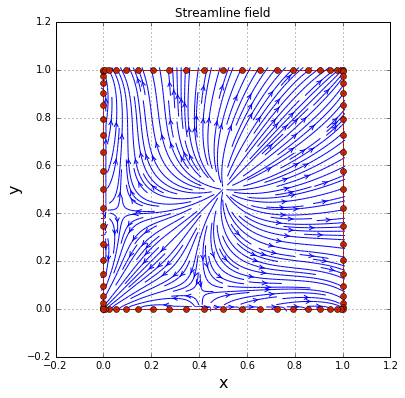

In [808]:
# plots the streamlines
%matplotlib inline

size = 6
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.title('Streamline field')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(-0.2, 1.2)
pyplot.ylim(-0.2, 1.2)


pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa), 
         numpy.append([panel.ya for panel in panels], panels[0].ya), 
         linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305');
stream =pyplot.streamplot(X, Y, u, v,density=2, linewidth=1, arrowsize=1, arrowstyle='->') #streamline
#cbar=pyplot.colorbar(orientation='vertical')

#equipotential=pyplot.contourf(X, Y, p1, extend='both')

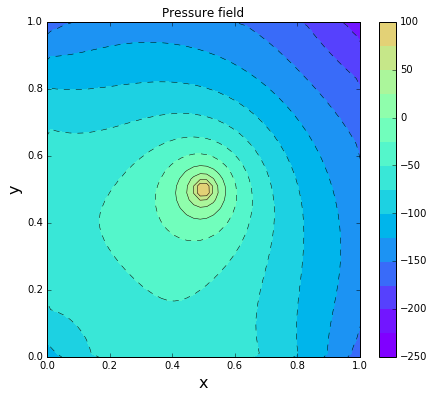

In [809]:
size = 7
pyplot.figure(figsize=(size, size-1))
pyplot.title('Pressure field')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(0, 1)
pyplot.ylim(0, 1)

pyplot.contour(X, Y, p, 15, linewidths=0.5, colors='k')
pyplot.contourf(X, Y, p, 15, cmap='rainbow',
                  vmax=abs(p).max(), vmin=-abs(p).max())
pyplot.colorbar()  # draw colorbar

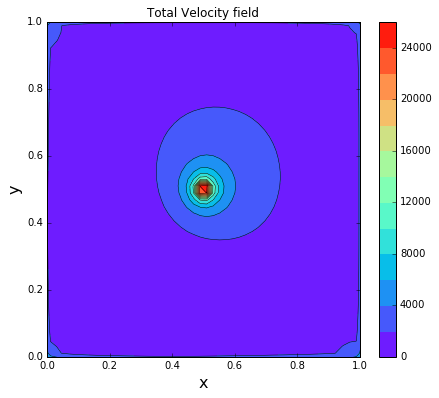

In [810]:
size = 7
pyplot.figure(figsize=(size, size-1))
pyplot.title('Total Velocity field')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(0, 1)
pyplot.ylim(0, 1)

Vtotal= numpy.sqrt(u**2+v**2)
#Vtotal= numpy.abs(v)
pyplot.contour(X, Y, Vtotal, 15, linewidths=0.5, colors='k')
pyplot.contourf(X, Y, Vtotal, 15, cmap='rainbow')
                  #vmax=50, vmin=0)
pyplot.colorbar()  # draw colorbar

array([ 3991.53526449,  4697.23214482,  4427.94528366,  4213.10279637,
        4056.60881842,  3935.0524005 ,  3835.61636196,  3758.7042195 ,
        3678.83215419,  3624.28803091,  3574.58365565,  3512.86339586,
        3477.97481989,  3446.47687207,  3393.90113729,  3365.99608357,
        3346.67520352,  3314.63917316,  3278.95525446,  3263.89905598,
        3249.45519765,  3219.13221798,  3199.8855574 ,  3188.04140691,
        3175.46727089,  3157.2693224 ,  3144.22991707,  3132.72142655,
        3123.92635749,  3118.96690841,  3108.32799206,  3098.56287193,
        3101.19357179,  3101.62102519,  3094.55662065,  3093.65095622,
        3110.17941018,  3111.68331515,  3115.93189462,  3141.31882334,
        3156.43775968,  3175.3078    ,  3215.96547724,  3250.99279038,
        3305.71980505,  3375.05945207,  3470.19304338,  3601.64257033,
        3743.87730196,  3061.23226415])

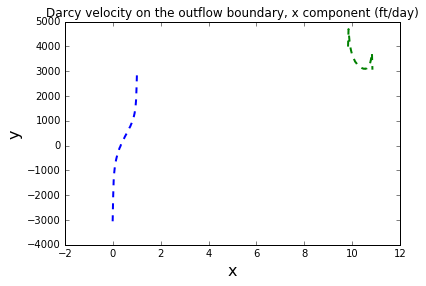

In [811]:
pyplot.title('Darcy velocity on the outflow boundary, x component (ft/day)')
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)

pyplot.plot(y, u[49,:], '--', linewidth=2)
pyplot.plot(9.8425+y, u[:,49], '--', linewidth=2)
u[:,49]

array([ 3991.53526449,  4697.23214482,  4427.94528366,  4213.10279637,
        4056.60881842,  3935.0524005 ,  3835.61636196,  3758.7042195 ,
        3678.83215419,  3624.28803091,  3574.58365565,  3512.86339586,
        3477.97481989,  3446.47687207,  3393.90113729,  3365.99608357,
        3346.67520352,  3314.63917316,  3278.95525446,  3263.89905598,
        3249.45519765,  3219.13221798,  3199.8855574 ,  3188.04140691,
        3175.46727089,  3157.2693224 ,  3144.22991707,  3132.72142655,
        3123.92635749,  3118.96690841,  3108.32799206,  3098.56287193,
        3101.19357179,  3101.62102519,  3094.55662065,  3093.65095622,
        3110.17941018,  3111.68331515,  3115.93189462,  3141.31882334,
        3156.43775968,  3175.3078    ,  3215.96547724,  3250.99279038,
        3305.71980505,  3375.05945207,  3470.19304338,  3601.64257033,
        3743.87730196,  3061.23226415])

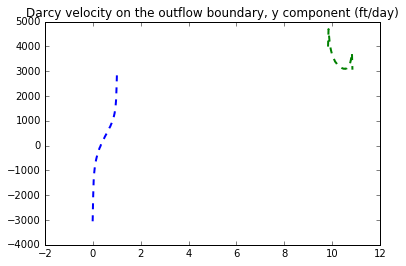

In [812]:
pyplot.title('Darcy velocity on the outflow boundary, y component (ft/day)')

pyplot.plot(y, v[:,49], '--', linewidth=2)
pyplot.plot(9.8425+y, v[49,:], '--', linewidth=2)
v[49,:]